# PyTorch Custom Datasets

How do you get your own data into PyTorch?
One of the ways to do so is: custom datasets.

## Importing PyTorch & Setting up Device Agnostic Code

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt



torch.__version__

'2.5.1+cu121'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Tue Jul 15 19:27:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8              4W /   30W |       9MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Get Data

Our dataset is a subset of Food101 dataset.

Food101 starts with 101 different classes of food and 1000 images per class (750 training & 250 testing).

Our dataset starts with 3 different classes of food and only 10% of the images (75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [4]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path("image_data/")
image_path = data_path / "pizza_steak_sushi"

# if the folde doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} directory already exists....skipping download")
else:
    print(f"{image_path} doesn't exist, creating one.....")

    image_path.mkdir(parents = True, exist_ok = True)


    # download the data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading the pizza, steak, sushi data....")

        f.write(request.content)


    # unzip the file
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("unzipping the data....")
        zip_ref.extractall(image_path)

image_data/pizza_steak_sushi directory already exists....skipping download


## Data Preparation & Data Exploration

In [5]:
import os

def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in image_data/pizza_steak_sushi.
There are 3 directories and 0 images in image_data/pizza_steak_sushi/train.
There are 0 directories and 78 images in image_data/pizza_steak_sushi/train/pizza.
There are 0 directories and 72 images in image_data/pizza_steak_sushi/train/sushi.
There are 0 directories and 75 images in image_data/pizza_steak_sushi/train/steak.
There are 3 directories and 0 images in image_data/pizza_steak_sushi/test.
There are 0 directories and 25 images in image_data/pizza_steak_sushi/test/pizza.
There are 0 directories and 31 images in image_data/pizza_steak_sushi/test/sushi.
There are 0 directories and 19 images in image_data/pizza_steak_sushi/test/steak.


In [7]:
# setup train & testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('image_data/pizza_steak_sushi/train'),
 PosixPath('image_data/pizza_steak_sushi/test'))

### Visualizing the Image

Let's write code to:

1. Get all of the image paths.
2. Pick a random image path using Python's `random.choice()`.
3. Get the image class name using Python's `pathlib.Path.parent.stem`.
4. Open the image with Python's PIL.
5. Show the image and print the metadata.

image_data/pizza_steak_sushi/train/pizza/786995.jpg
pizza


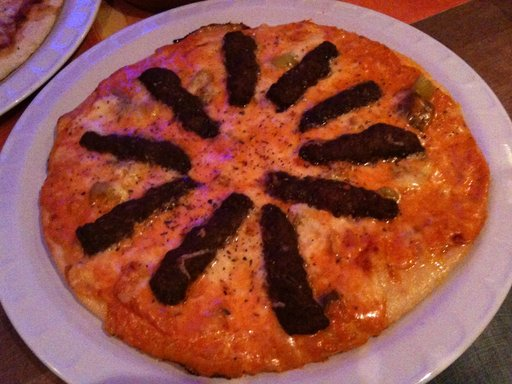

In [8]:
import random
from PIL import Image

random.seed(42)

# get all the images path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# get the image class from the path name
image_class = random_image_path.parent.stem
print(image_class)

# open the image
img = Image.open(random_image_path)
img

In [9]:
# turn the image into numpy array
image_as_array = np.asarray(img)
image_as_array

array([[[138,  79,  81],
        [153,  94,  96],
        [152,  91,  96],
        ...,
        [ 75,  29,  31],
        [ 76,  27,  31],
        [ 73,  24,  28]],

       [[131,  71,  73],
        [138,  78,  80],
        [148,  87,  92],
        ...,
        [ 78,  32,  32],
        [ 78,  29,  32],
        [ 74,  25,  28]],

       [[134,  72,  75],
        [142,  80,  83],
        [145,  83,  88],
        ...,
        [ 77,  32,  29],
        [ 73,  27,  27],
        [ 68,  22,  22]],

       ...,

       [[ 68,  31,  39],
        [ 72,  35,  43],
        [ 69,  32,  40],
        ...,
        [ 74,  63,  57],
        [ 78,  64,  63],
        [ 83,  69,  69]],

       [[ 66,  31,  38],
        [ 67,  32,  39],
        [ 63,  28,  35],
        ...,
        [ 77,  67,  58],
        [ 81,  67,  64],
        [ 84,  70,  69]],

       [[ 73,  38,  45],
        [ 72,  37,  44],
        [ 69,  34,  41],
        ...,
        [ 75,  65,  56],
        [ 80,  66,  63],
        [ 82,  68,  67]]

## Transforming Data

Before we can use our image data with PyTorch:

1. Turn your target data into tensors (numerical representation of our images)
2. Turn it into `torch.utils.data.Dataset` & and subsequently a `torch.utils.data.dataLoader` 

### Transforming Data With `torchvision.transforms`

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
# write a transform for image
data_transform = transforms.Compose([
    # resize the image to 64x64
    transforms.Resize(size=(64, 64)),

    # flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),

    # turn the image into tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img)

tensor([[[0.2863, 0.2824, 0.3020,  ..., 0.4667, 0.5255, 0.5490],
         [0.2863, 0.3020, 0.3373,  ..., 0.3804, 0.5176, 0.5098],
         [0.2706, 0.3059, 0.3333,  ..., 0.2706, 0.4392, 0.5333],
         ...,
         [0.3059, 0.2902, 0.2706,  ..., 0.2784, 0.2706, 0.2706],
         [0.3098, 0.2824, 0.2549,  ..., 0.2941, 0.2863, 0.2863],
         [0.2980, 0.2745, 0.2471,  ..., 0.2824, 0.2784, 0.2784]],

        [[0.1216, 0.1216, 0.1333,  ..., 0.2039, 0.2549, 0.2980],
         [0.1333, 0.1412, 0.1608,  ..., 0.1373, 0.2863, 0.2902],
         [0.1255, 0.1412, 0.1608,  ..., 0.0627, 0.2157, 0.3137],
         ...,
         [0.2588, 0.2471, 0.2314,  ..., 0.1373, 0.1333, 0.1333],
         [0.2667, 0.2471, 0.2275,  ..., 0.1373, 0.1333, 0.1333],
         [0.2627, 0.2471, 0.2353,  ..., 0.1412, 0.1333, 0.1333]],

        [[0.0863, 0.0745, 0.0863,  ..., 0.2667, 0.3373, 0.3451],
         [0.0902, 0.0941, 0.1059,  ..., 0.2118, 0.4235, 0.3804],
         [0.0824, 0.0941, 0.1020,  ..., 0.1137, 0.3137, 0.

In [13]:
def plot_transformed_images(image_paths, transform, n = 3, seed = None):
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k = n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows = 1, ncols = 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # tranform and plot the target image
            tranformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(tranformed_image)
            ax[1].set_title(f"Tranformed\nSize: {tranformed_image.shape}")
            ax[1].axis(False)

    

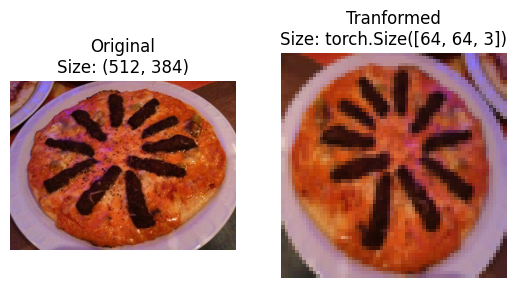

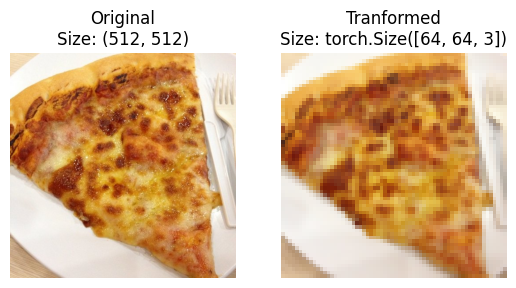

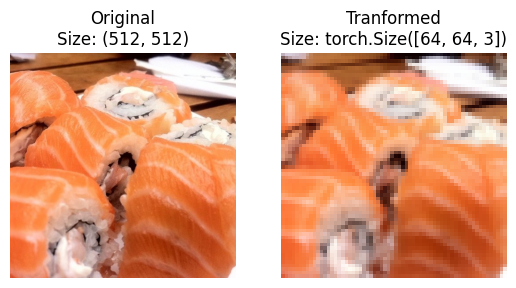

In [14]:
plot_transformed_images(image_paths = image_path_list,
                       transform = data_transform,
                       n = 3,
                       seed = 42)

### Load Image Data Using `ImgaeFolder`

In [15]:
# use Imagefolder to create datasets
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,  # transform for the data
                                  target_transform = None)   # transform for data/target

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: image_data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: image_data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
img, label = train_data[0]
img, label

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

### Create a DataLoader


In [18]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              shuffle = True,
                              batch_size = BATCH_SIZE)

test_dataloader = DataLoader(dataset = test_data,
                             shuffle = False,
                             batch_size = BATCH_SIZE)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79436f11dc70>,
 <torch.utils.data.dataloader.DataLoader at 0x79436f3fa420>)

In [19]:
len(train_dataloader), len(test_dataloader)

(8, 3)

## Data Augmentation

It's the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various transformation on training images.

In [20]:
train_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = ((224, 224))),
    transforms.ToTensor()
])

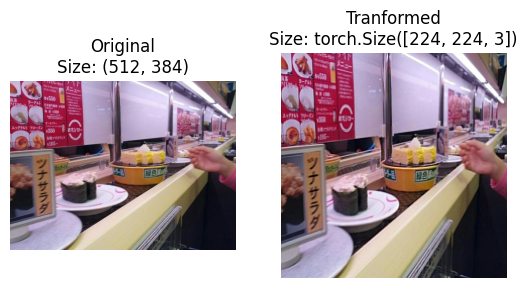

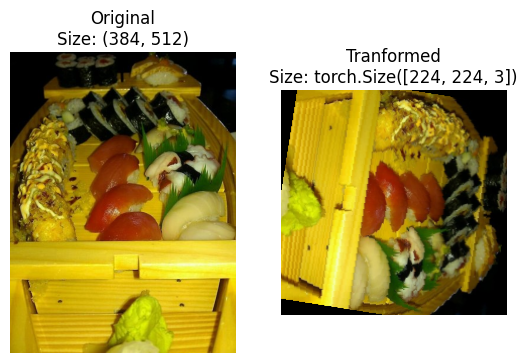

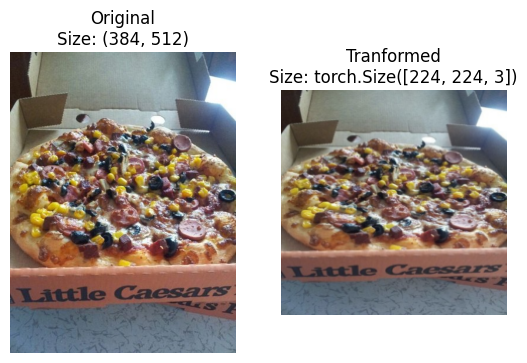

In [21]:
plot_transformed_images(image_paths=image_path_list,
                        transform = train_transform,
                        n = 3)

## Model 0: TinyVGG Without Data Augmentation

### Creating Transforms & Loading The Data For Model 0

In [22]:
# create transform
simple_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

In [23]:
# load the images
train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = simple_transform)


train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: image_data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: image_data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [24]:
# create dataloader
NUM_WORKERS = os.cpu_count()
SAFE_NUM_WORKERS = NUM_WORKERS - 5

train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     shuffle = True,
                                     batch_size = BATCH_SIZE,
                                     num_workers = SAFE_NUM_WORKERS)


test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = SAFE_NUM_WORKERS)


train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x79436e0d9b80>,
 <torch.utils.data.dataloader.DataLoader at 0x79436e06a5a0>)

### Create TinyVGG Model Class


In [25]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),

            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,   
                      padding = 0),

            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),

            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * 13 * 13,
                      out_features = output_shape)
        )

    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [26]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### Try a Forward Pass To Troubleshoot

In [27]:
# get a single image
image_batch, label_batch = next(iter(train_dataloader_simple))
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9130e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1470e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.3062e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### Use `torchinfo` To Get The Info Of The Model

In [28]:
from torchinfo import summary
summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### Create Train & Test Loop Functions

In [29]:
def train_step(model: nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            device):
    
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        train_loss = train_loss + loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # find the accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc = train_acc + (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


In [30]:
def test_step(model: nn.Module,
              loss_fn: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              device):
    
    model.eval()

    with torch.inference_mode():
        test_loss, test_acc = 0, 0

        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)
            test_loss = test_loss + loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc = test_acc + (y_pred_class == y).sum().item() / len(y_pred)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

### Create a `train()` Function To Combine `train_step()` & `test_step()`

In [31]:
from tqdm.auto import tqdm

def train(model: nn.Module,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          train_data: torch.utils.data.DataLoader,
          test_data: torch.utils.data.DataLoader,
          device, epochs: int):
    
    results = {"train_loss": [],
                "train_acc": [],
                "test_loss": [],
                "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_data, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, loss_fn = loss_fn, dataloader = test_data, device = device)

        train_acc = train_acc * 100
        test_acc = test_acc * 100
        
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

        results["train_acc"].append(train_acc)
        results["test_acc"].append(test_acc)
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return results


/home/programmer/PyTorch Project/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Train & Evaluate Model 0

In [32]:
from timeit import default_timer as timer

torch.manual_seed(42)

NUM_EPOCHS = 20

model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 64,
                  output_shape =  len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

# start the timer
start_time = timer()

model_0_results = train(model_0, train_data = train_dataloader_simple,
                        test_data = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)

end_time = timer()

print(f"Total training time: {end_time - start_time:.3f} seconds")

  5%|▌         | 1/20 [00:01<00:19,  1.05s/it]

Epoch: 0 | Train Loss: 1.1035 | Train Acc: 33.5938 | Test Loss: 1.0789 | Test Acc: 29.1667


 10%|█         | 2/20 [00:02<00:20,  1.11s/it]

Epoch: 1 | Train Loss: 1.0264 | Train Acc: 53.5156 | Test Loss: 1.0407 | Test Acc: 39.2045


 15%|█▌        | 3/20 [00:03<00:19,  1.17s/it]

Epoch: 2 | Train Loss: 0.8109 | Train Acc: 63.6719 | Test Loss: 1.0655 | Test Acc: 41.2879


 20%|██        | 4/20 [00:04<00:19,  1.19s/it]

Epoch: 3 | Train Loss: 0.7495 | Train Acc: 64.4531 | Test Loss: 1.0683 | Test Acc: 49.4318


 25%|██▌       | 5/20 [00:05<00:17,  1.19s/it]

Epoch: 4 | Train Loss: 0.7736 | Train Acc: 69.9219 | Test Loss: 1.4559 | Test Acc: 35.3220


 30%|███       | 6/20 [00:06<00:16,  1.15s/it]

Epoch: 5 | Train Loss: 0.8958 | Train Acc: 63.6719 | Test Loss: 1.0418 | Test Acc: 49.4318


 35%|███▌      | 7/20 [00:07<00:14,  1.12s/it]

Epoch: 6 | Train Loss: 0.7967 | Train Acc: 72.6562 | Test Loss: 1.0528 | Test Acc: 49.5265


 40%|████      | 8/20 [00:09<00:13,  1.12s/it]

Epoch: 7 | Train Loss: 0.7837 | Train Acc: 60.5469 | Test Loss: 1.0370 | Test Acc: 55.3977


 45%|████▌     | 9/20 [00:10<00:12,  1.15s/it]

Epoch: 8 | Train Loss: 0.8418 | Train Acc: 48.0469 | Test Loss: 1.0768 | Test Acc: 40.4356


 50%|█████     | 10/20 [00:11<00:11,  1.19s/it]

Epoch: 9 | Train Loss: 0.9123 | Train Acc: 53.9062 | Test Loss: 1.1102 | Test Acc: 42.4242


 55%|█████▌    | 11/20 [00:12<00:10,  1.21s/it]

Epoch: 10 | Train Loss: 0.7834 | Train Acc: 69.5312 | Test Loss: 1.0248 | Test Acc: 48.3902


 60%|██████    | 12/20 [00:14<00:09,  1.24s/it]

Epoch: 11 | Train Loss: 0.6746 | Train Acc: 67.5781 | Test Loss: 1.0826 | Test Acc: 51.4205


 65%|██████▌   | 13/20 [00:15<00:08,  1.27s/it]

Epoch: 12 | Train Loss: 0.6110 | Train Acc: 73.0469 | Test Loss: 1.2601 | Test Acc: 42.4242


 70%|███████   | 14/20 [00:16<00:07,  1.25s/it]

Epoch: 13 | Train Loss: 0.5712 | Train Acc: 76.9531 | Test Loss: 1.2313 | Test Acc: 43.3712


 75%|███████▌  | 15/20 [00:17<00:05,  1.19s/it]

Epoch: 14 | Train Loss: 0.4886 | Train Acc: 81.2500 | Test Loss: 1.5474 | Test Acc: 41.5720


 80%|████████  | 16/20 [00:18<00:04,  1.16s/it]

Epoch: 15 | Train Loss: 0.4350 | Train Acc: 82.0312 | Test Loss: 1.3292 | Test Acc: 54.4508


 85%|████████▌ | 17/20 [00:20<00:03,  1.19s/it]

Epoch: 16 | Train Loss: 0.4005 | Train Acc: 87.8906 | Test Loss: 1.5361 | Test Acc: 45.4545


 90%|█████████ | 18/20 [00:21<00:02,  1.24s/it]

Epoch: 17 | Train Loss: 0.3459 | Train Acc: 85.9375 | Test Loss: 1.8073 | Test Acc: 44.4129


 95%|█████████▌| 19/20 [00:22<00:01,  1.28s/it]

Epoch: 18 | Train Loss: 0.3799 | Train Acc: 86.7188 | Test Loss: 1.4196 | Test Acc: 45.3598


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]

Epoch: 19 | Train Loss: 0.2249 | Train Acc: 91.7969 | Test Loss: 1.6902 | Test Acc: 56.7235
Total training time: 23.987 seconds


### Plot The Loss Curves

In [33]:
def plot_loss_curves(results: dict[str, list[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(loss))
    plt.figure(figsize = (15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "train_loss")
    plt.plot(epochs, test_loss, label = "test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "train_acc")
    plt.plot(epochs, test_accuracy, label = "test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


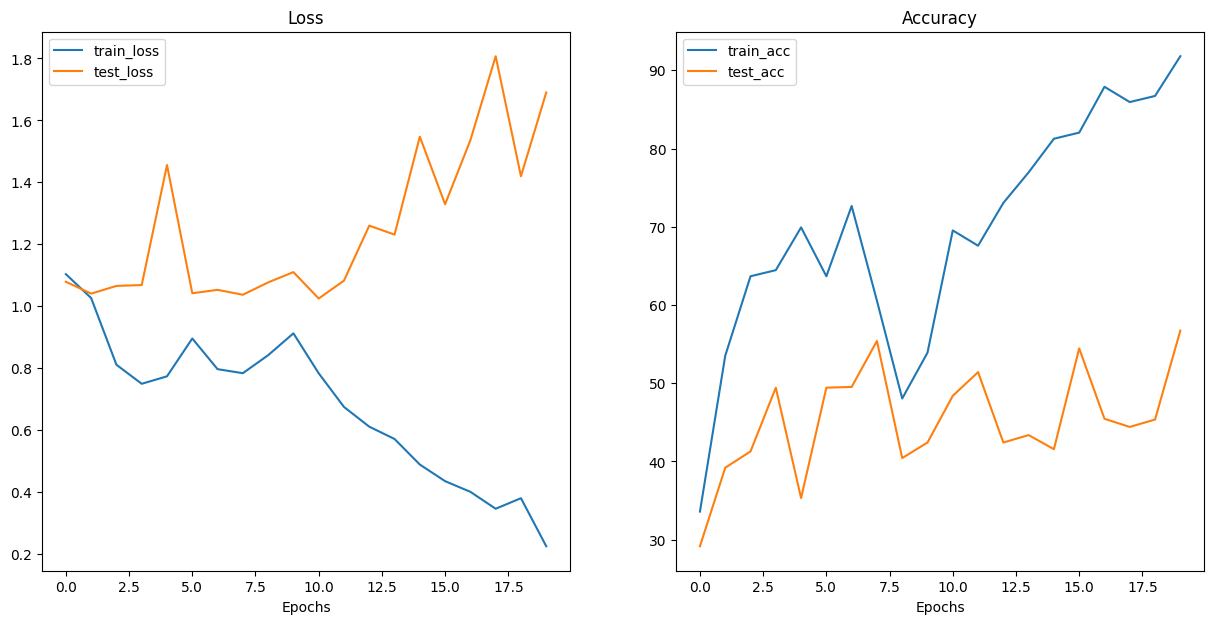

In [34]:
plot_loss_curves(results = model_0_results)

## Model 1: TinyVGG With Data Augmentation

### Create `transform` & `dataloader` For Data Augmentation

In [35]:
train_transform_trivial = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

In [36]:
train_data_augmented = datasets.ImageFolder(root = train_dir,
                                            transform = train_transform_trivial)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = test_transform_simple)

In [37]:
# create dataloader
BATCH_SIZE = 32

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset = train_data_augmented,
                                        shuffle = True,
                                        batch_size = BATCH_SIZE,
                                        num_workers = SAFE_NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    shuffle = False,
                                    batch_size = BATCH_SIZE,
                                    num_workers = SAFE_NUM_WORKERS)



### Construct & Train Model 1

In [38]:
torch.manual_seed(42)

model_1 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.001)

NUM_EPOCHS = 5

In [40]:
start_time = timer()

# train the model
model_1_results = train(model = model_1, 
                        loss_fn = loss_fn,
                        optimizer = optimizer,
                        train_data = train_dataloader_augmented,
                        test_data = test_dataloader_simple,
                        epochs = NUM_EPOCHS,
                        device = device)

end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:01<00:04,  1.20s/it]

Epoch: 0 | Train Loss: 1.1067 | Train Acc: 30.0781 | Test Loss: 1.0994 | Test Acc: 26.0417


 40%|████      | 2/5 [00:02<00:03,  1.17s/it]

Epoch: 1 | Train Loss: 1.0999 | Train Acc: 30.8594 | Test Loss: 1.0717 | Test Acc: 54.1667


 60%|██████    | 3/5 [00:03<00:02,  1.15s/it]

Epoch: 2 | Train Loss: 1.0912 | Train Acc: 32.8125 | Test Loss: 1.0842 | Test Acc: 45.1705


 80%|████████  | 4/5 [00:04<00:01,  1.16s/it]

Epoch: 3 | Train Loss: 1.1008 | Train Acc: 32.4219 | Test Loss: 1.0641 | Test Acc: 58.3333


100%|██████████| 5/5 [00:06<00:00,  1.20s/it]

Epoch: 4 | Train Loss: 1.0908 | Train Acc: 36.3281 | Test Loss: 1.0829 | Test Acc: 41.1932
Total training time: 6.009 seconds
